In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning import LightningModule, LightningDataModule

from scipy import stats
import os
datadir = '../data/'

BATCH_SIZE=8


# log into to wandb to log results
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tomy-lorant (lorant). Use `wandb login --relogin` to force relogin


True

Pip commands to download libraries to access the data set from hugging face

In [2]:
!pip install pytorch-lightning

In [3]:
!pip install fsspec
!pip install huggingface_hub

In [4]:
df = pd.read_csv("hf://datasets/nateraw/airbnb-stock-price/airbnb-stock-price.zip")

c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df.head()

,Date,Adj.Close,Volume,Open,High,Low
0,06/03/22,119.83,4584611.0,118.07,121.50,117.56
1,06/02/22,121.26,5177244.0,117.13,123.00,116.27
2,06/01/22,116.72,6879606.0,121.05,121.07,114.40
3,05/31/22,120.87,9117555.0,120.50,122.30,117.16
4,05/27/22,120.50,7391500.0,116.00,120.70,115.77


One problem I see is the format of the date. I need it to have a numerical value so that the model can understand it. After doing some research, I found that one way to do it is separating the date into three different features: day, month, and year.<br><br>

Then, I realized that simply splitting the date into three features lacks the key relationship of January being as close to December as June is to July, because it would interpret them as 0 and 11 being far apart and 5 and 6 as being close. A solution to this is applying the sine and cosine transformations to the days and moths to maintain the cyclic relationship property they have. 

In [6]:
type(df['Date'][0])

pattern = r"^\d{2}/\d{2}/\d{2}$"

invalid_dates = df['Date'][~df['Date'].str.match(pattern, na=False)]

# contains_slash = df['Date'][df['Date'].str.contains('-')]
print(invalid_dates.shape)
invalid_dates
print(df.head())
test = pd.to_datetime(df['Date'], format='%m/%d/%y')
test.head()

(0,)
       Date  Adj.Close     Volume    Open    High     Low
0  06/03/22     119.83  4584611.0  118.07  121.50  117.56
1  06/02/22     121.26  5177244.0  117.13  123.00  116.27
2  06/01/22     116.72  6879606.0  121.05  121.07  114.40
3  05/31/22     120.87  9117555.0  120.50  122.30  117.16
4  05/27/22     120.50  7391500.0  116.00  120.70  115.77


0   2022-06-03
1   2022-06-02
2   2022-06-01
3   2022-05-31
4   2022-05-27
Name: Date, dtype: datetime64[ns]

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
print(type(df['Date'][0]))
print(df.head())

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
        Date  Adj.Close     Volume    Open    High     Low
0 2022-06-03     119.83  4584611.0  118.07  121.50  117.56
1 2022-06-02     121.26  5177244.0  117.13  123.00  116.27
2 2022-06-01     116.72  6879606.0  121.05  121.07  114.40
3 2022-05-31     120.87  9117555.0  120.50  122.30  117.16
4 2022-05-27     120.50  7391500.0  116.00  120.70  115.77


In [8]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

df.head()

,Date,Adj.Close,Volume,Open,High,Low,year,month,day
0,2022-06-03,119.83,4584611.0,118.07,121.50,117.56,2022,6,3
1,2022-06-02,121.26,5177244.0,117.13,123.00,116.27,2022,6,2
2,2022-06-01,116.72,6879606.0,121.05,121.07,114.40,2022,6,1
3,2022-05-31,120.87,9117555.0,120.50,122.30,117.16,2022,5,31
4,2022-05-27,120.50,7391500.0,116.00,120.70,115.77,2022,5,27


In [9]:
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)

df['day_sin'] = np.sin(2*np.pi*df['day']/7)
df['day_cos'] = np.cos(2*np.pi*df['day']/7)

df.head()

,Date,Adj.Close,Volume,Open,High,Low,year,month,day,month_sin,month_cos,day_sin,day_cos
0,2022-06-03,119.83,4584611.0,118.07,121.50,117.56,2022,6,3,1.224647e-16,-1.000000,0.433884,-0.900969
1,2022-06-02,121.26,5177244.0,117.13,123.00,116.27,2022,6,2,1.224647e-16,-1.000000,0.974928,-0.222521
2,2022-06-01,116.72,6879606.0,121.05,121.07,114.40,2022,6,1,1.224647e-16,-1.000000,0.781831,0.623490
3,2022-05-31,120.87,9117555.0,120.50,122.30,117.16,2022,5,31,5.000000e-01,-0.866025,0.433884,-0.900969
4,2022-05-27,120.50,7391500.0,116.00,120.70,115.77,2022,5,27,5.000000e-01,-0.866025,-0.781831,0.623490


In [10]:
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

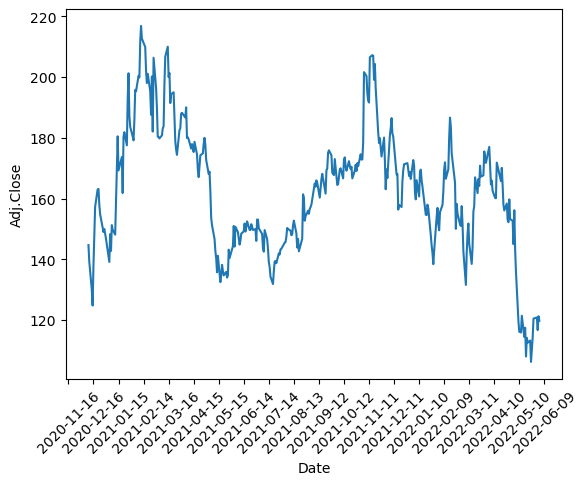

In [11]:
import matplotlib.dates as mdates

plt.plot(df['Date'], df['Adj.Close'])
plt.xlabel('Date')
plt.ylabel('Adj.Close')

# Sets how often the dates should appear. (in this case it is every 30 days)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
# Format how the dates should appear
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Rotate the date labels for better visibility
plt.xticks(rotation=45)

plt.show()

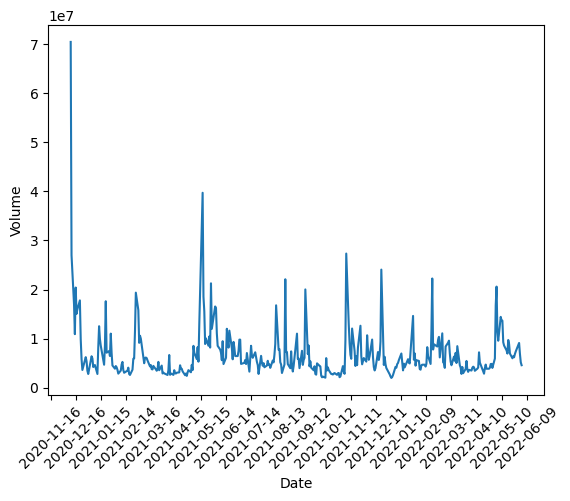

In [12]:
plt.plot(df['Date'], df['Volume'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

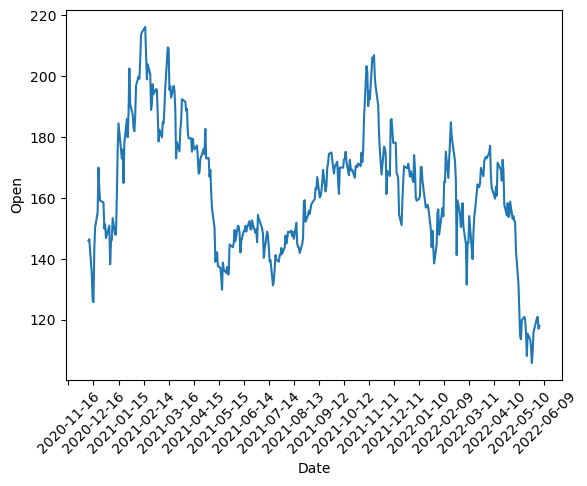

In [13]:
plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

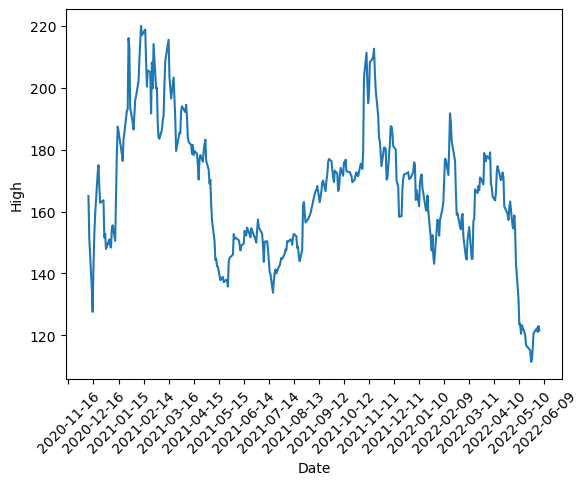

In [14]:
plt.plot(df['Date'], df['High'])
plt.xlabel('Date')
plt.ylabel('High')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

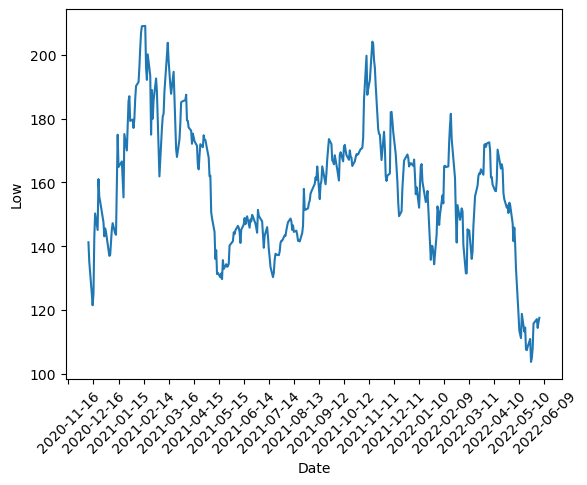

In [15]:
plt.plot(df['Date'], df['Low'])
plt.xlabel('Date')
plt.ylabel('Low')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

In [16]:
!pip install pytorch-lightning

The value this model will be predicting the stock's price change. Which is calculated with the following formula:<br><br>

$$ y = \frac{\text{Adj. Close}[t+1] - \text{Adj. Close}[t]}{\text{Adj. Close}[t]} $$

In [17]:
df['price_change'] = df['Adj.Close'].pct_change()
df.head()

,Date,Adj.Close,Volume,Open,High,Low,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change
0,2022-06-03,119.83,4584611.0,118.07,121.50,117.56,2022,6,3,1.224647e-16,-1.000000,0.433884,-0.900969,NaN
1,2022-06-02,121.26,5177244.0,117.13,123.00,116.27,2022,6,2,1.224647e-16,-1.000000,0.974928,-0.222521,0.011934
2,2022-06-01,116.72,6879606.0,121.05,121.07,114.40,2022,6,1,1.224647e-16,-1.000000,0.781831,0.623490,-0.037440
3,2022-05-31,120.87,9117555.0,120.50,122.30,117.16,2022,5,31,5.000000e-01,-0.866025,0.433884,-0.900969,0.035555
4,2022-05-27,120.50,7391500.0,116.00,120.70,115.77,2022,5,27,5.000000e-01,-0.866025,-0.781831,0.623490,-0.003061


In [18]:
nulls = df.isna().sum()
nulls

Date            0
Adj.Close       0
Volume          0
Open            0
High            0
Low             0
year            0
month           0
day             0
month_sin       0
month_cos       0
day_sin         0
day_cos         0
price_change    1
dtype: int64

In [19]:
df['price_change'] = df['price_change'].fillna(0)
df.head()

,Date,Adj.Close,Volume,Open,High,Low,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change
0,2022-06-03,119.83,4584611.0,118.07,121.50,117.56,2022,6,3,1.224647e-16,-1.000000,0.433884,-0.900969,0.000000
1,2022-06-02,121.26,5177244.0,117.13,123.00,116.27,2022,6,2,1.224647e-16,-1.000000,0.974928,-0.222521,0.011934
2,2022-06-01,116.72,6879606.0,121.05,121.07,114.40,2022,6,1,1.224647e-16,-1.000000,0.781831,0.623490,-0.037440
3,2022-05-31,120.87,9117555.0,120.50,122.30,117.16,2022,5,31,5.000000e-01,-0.866025,0.433884,-0.900969,0.035555
4,2022-05-27,120.50,7391500.0,116.00,120.70,115.77,2022,5,27,5.000000e-01,-0.866025,-0.781831,0.623490,-0.003061


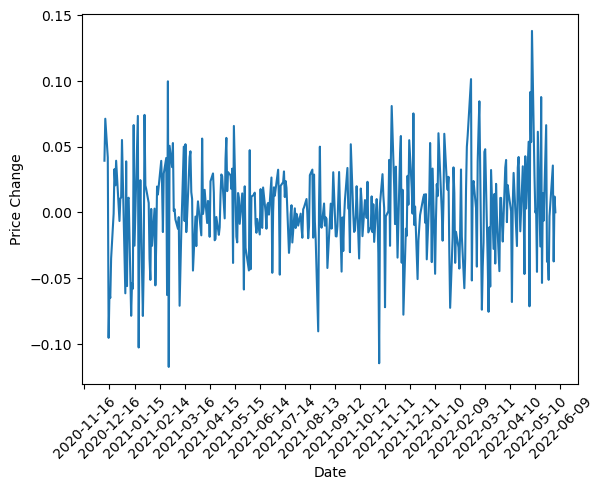

In [20]:
plt.plot(df['Date'], df['price_change'])
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

Since I am trying to predict the future trends of the stock, I have to do a time-based split. What this means is making the testing data the values of the stock at earlier dates and the testing data the later values form the data set.

In [21]:
split_index1 = int(df.shape[0] * 0.2)
split_index2 = int(df.shape[0] * 0.1)

print(split_index1)
print(split_index2)

test_df = df.iloc[:split_index2]
val_df = df.iloc[split_index2:split_index1]
train_df = df.iloc[split_index1:]



print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(df.shape)


74
37
(299, 14)
(37, 14)
(37, 14)
(373, 14)


In [22]:
print(train_df.iloc[0])
print(val_df.iloc[0])

Date            2022-02-16 00:00:00
Adj.Close                    186.64
Volume                   22252850.0
Open                          178.3
High                         191.73
Low                           178.0
year                           2022
month                             2
day                              16
month_sin                  0.866025
month_cos                       0.5
day_sin                    0.974928
day_cos                   -0.222521
price_change               0.016558
Name: 74, dtype: object
Date            2022-04-11 00:00:00
Adj.Close                    160.25
Volume                    3877215.0
Open                         159.84
High                         163.57
Low                          157.41
year                           2022
month                             4
day                              11
month_sin                  0.866025
month_cos                      -0.5
day_sin                   -0.433884
day_cos                   -0.900969
pric

In [23]:
print(test_df.iloc[0])

Date            2022-06-03 00:00:00
Adj.Close                    119.83
Volume                    4584611.0
Open                         118.07
High                          121.5
Low                          117.56
year                           2022
month                             6
day                               3
month_sin                       0.0
month_cos                      -1.0
day_sin                    0.433884
day_cos                   -0.900969
price_change                    0.0
Name: 0, dtype: object


In [24]:
class Data(Dataset):
    def __init__(self, df):
        self.x = torch.tensor(df.drop(columns=['price_change','Date', 'Adj.Close','month', 'day']).values, dtype = torch.float32)
        self.y = torch.tensor(df['price_change'].values, dtype=torch.float32)
        self.len = df.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
train_ds = Data(train_df)
test_ds = Data(test_df)
val_ds = Data(val_df)

Test if the Dataset class and DataLoader works.

In [25]:
train_loader = DataLoader(train_ds,shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)
test = next(iter(train_loader))
test

[tensor([[ 2.2253e+07,  1.7830e+02,  1.9173e+02,  1.7800e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  9.7493e-01, -2.2252e-01],
         [ 1.1734e+07,  1.7292e+02,  1.8063e+02,  1.7275e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  7.8183e-01,  6.2349e-01],
         [ 4.8476e+06,  1.6663e+02,  1.7180e+02,  1.6503e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01, -4.8986e-16,  1.0000e+00],
         [ 6.4644e+06,  1.7531e+02,  1.7674e+02,  1.6483e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01, -4.3388e-01, -9.0097e-01],
         [ 8.2614e+06,  1.6525e+02,  1.7706e+02,  1.6525e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  4.3388e-01, -9.0097e-01],
         [ 4.8683e+06,  1.6537e+02,  1.7007e+02,  1.6508e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  9.7493e-01, -2.2252e-01],
         [ 4.3091e+06,  1.5400e+02,  1.6308e+02,  1.5344e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  7.8183e-01,  6.2349e-01],
         [ 4.6907e+06,  1.5679e+02

In [26]:
class StockDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size=8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
    def prepare_data(self):
        # Download data
        if not os.path.exists(self.data_dir + 'stock_values.csv'):
            df = pd.read_csv("hf://datasets/nateraw/airbnb-stock-price/airbnb-stock-price.zip")
            df.to_csv(self.data_dir + 'stock_values.csv', index=False)


    def setup(self, stage=None):
        self.prepare_data()
        df = pd.read_csv(self.data_dir + 'stock_values.csv')

        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day

        df['month_sin'] = np.sin(2*np.pi*df['month']/12)
        df['month_cos'] = np.cos(2*np.pi*df['month']/12)

        df['day_sin'] = np.sin(2*np.pi*df['day']/7)
        df['day_cos'] = np.cos(2*np.pi*df['day']/7)

        df['price_change'] = df['Adj.Close'].pct_change()

        df['price_change'] = df['price_change'].fillna(0)

        split_index1 = int(df.shape[0] * 0.2)
        split_index2 = int(df.shape[0] * 0.1)

        self.test_df = df.iloc[:split_index2]
        self.val_df = df.iloc[split_index2:split_index1]
        self.train_df = df.iloc[split_index1:]

        self.train_df.to_csv(self.data_dir + "train_df", index=False)
        self.test_df.to_csv(self.data_dir + "test_df", index=False)
        self.val_df.to_csv(self.data_dir + "val_df", index=False)


    def train_dataloader(self):
        return DataLoader(Data(self.train_df), batch_size=self.batch_size, shuffle=False, drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(Data(self.val_df), batch_size=self.batch_size, shuffle=False, drop_last=True)
    
    def test_dataloader(self):
        return DataLoader(Data(self.test_df), batch_size=self.batch_size, shuffle=False, drop_last=True)


In [27]:
dm = StockDataModule(datadir, batch_size=BATCH_SIZE)
dm.setup()
test = next(iter(dm.train_dataloader()))
test

[tensor([[ 2.2253e+07,  1.7830e+02,  1.9173e+02,  1.7800e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  9.7493e-01, -2.2252e-01],
         [ 1.1734e+07,  1.7292e+02,  1.8063e+02,  1.7275e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  7.8183e-01,  6.2349e-01],
         [ 4.8476e+06,  1.6663e+02,  1.7180e+02,  1.6503e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01, -4.8986e-16,  1.0000e+00],
         [ 6.4644e+06,  1.7531e+02,  1.7674e+02,  1.6483e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01, -4.3388e-01, -9.0097e-01],
         [ 8.2614e+06,  1.6525e+02,  1.7706e+02,  1.6525e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  4.3388e-01, -9.0097e-01],
         [ 4.8683e+06,  1.6537e+02,  1.7007e+02,  1.6508e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  9.7493e-01, -2.2252e-01],
         [ 4.3091e+06,  1.5400e+02,  1.6308e+02,  1.5344e+02,  2.0220e+03,
           8.6603e-01,  5.0000e-01,  7.8183e-01,  6.2349e-01],
         [ 4.6907e+06,  1.5679e+02

In [28]:
# TODO: try doing it with LSTM

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.l = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x):
        _ ,h_n = self.rnn(x)
        x = self.l(h_n)
        print("len of x: ", x.shape)
        return x

In [29]:
print(train_df.drop(columns = 'price_change').iloc[0])

Date         2022-02-16 00:00:00
Adj.Close                 186.64
Volume                22252850.0
Open                       178.3
High                      191.73
Low                        178.0
year                        2022
month                          2
day                           16
month_sin               0.866025
month_cos                    0.5
day_sin                 0.974928
day_cos                -0.222521
Name: 74, dtype: object


In [30]:
# train_ds
c = nn.MSELoss()
tmodel = RNN(input_size=train_ds.x.shape[1], hidden_size=10, num_layers=8, output_size=1)
ydhat = tmodel(val_ds.x).squeeze()
print(ydhat.shape)
print(val_ds.y.shape)
print(ydhat.squeeze().shape)
print(c(ydhat, val_ds.y[0:8]))

len of x:  torch.Size([8, 1])
torch.Size([8])
torch.Size([37])
torch.Size([8])
tensor(0.1421, grad_fn=<MseLossBackward0>)


In [31]:
criterion = nn.MSELoss()
criterion_name = 'MSE'

architecture = 'RNN'

time_encoding = 'sin-cos'

num_layers = 8
hidden_size = 10
input_size = train_ds.x.shape[1]
output_size = 1 # Because we are trying to predict weather the Adjusted Closing value will be higher or lower than the current Adjusted Closing Value
lr = 0.1
optim_name = 'Adam'

I will use the spearman corelation to measure the relationship between features

In [32]:
class litModule(L.LightningModule):
    def __init__(self, model, criterion, lr):
        super().__init__()
        self.model = model
        self.loss = criterion
        self.spear = stats.spearmanr
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.model(x).squeeze()
        print('TRAINING STEP: ', yhat.shape, '  = ',y.shape)
        loss = self.loss(yhat, y)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # In theory, you don't need the with no torch grad because the lightning module does it for you
        with torch.no_grad():
            yhat = self.model(x).squeeze()
            print('VALIDATION STEP: ', yhat.shape, '  = ',y.shape)
            loss = self.loss(yhat, y)
            self.log('val_loss', loss)

            spearman = self.spear(yhat, y).statistic
            self.log('val_spearman', spearman, on_step = False, on_epoch = True, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


In [33]:
model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
lit_model = litModule(model, criterion=criterion, lr=lr)

In [34]:
# use weights and biases logger
wandb_logger = WandbLogger(project='airbnb_stock_price_prediction', name = architecture)
wandb_logger.experiment.config.update({
    "lr": lr,
    "batch_size": BATCH_SIZE,
    "arch": architecture,
    "time_enc": time_encoding,
    "loss": criterion_name,
    "opt": optim_name
})

# train model
trainer = L.Trainer(max_epochs=10, logger = wandb_logger)
# trainer.validate(model = lit_model, datamodule = dm)
trainer.fit(model = lit_model, datamodule = dm)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | RNN     | 1.8 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]len of x:  torch.Size([8, 1])
VALIDATION STEP:  torch.Size([8])   =  torch.Size([8])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 46.05it/s]len of x:  torch.Size([8, 1])
VALIDATION STEP:  torch.Size([8])   =  torch.Size([8])
                                                                           

c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/37 [00:00<?, ?it/s] len of x:  torch.Size([8, 1])
TRAINING STEP:  torch.Size([8])   =  torch.Size([8])
Epoch 0:   3%|▎         | 1/37 [00:00<00:00, 45.49it/s, v_num=brqk, train_loss_step=0.129]len of x:  torch.Size([8, 1])
TRAINING STEP:  torch.Size([8])   =  torch.Size([8])
Epoch 0:   5%|▌         | 2/37 [00:00<00:00, 53.15it/s, v_num=brqk, train_loss_step=0.369]len of x:  torch.Size([8, 1])
TRAINING STEP:  torch.Size([8])   =  torch.Size([8])
Epoch 0:   8%|▊         | 3/37 [00:00<00:00, 54.25it/s, v_num=brqk, train_loss_step=0.231]len of x:  torch.Size([8, 1])
TRAINING STEP:  torch.Size([8])   =  torch.Size([8])
Epoch 0:  11%|█         | 4/37 [00:00<00:00, 56.30it/s, v_num=brqk, train_loss_step=0.0617]len of x:  torch.Size([8, 1])
TRAINING STEP:  torch.Size([8])   =  torch.Size([8])
Epoch 0:  14%|█▎        | 5/37 [00:00<00:00, 56.09it/s, v_num=brqk, train_loss_step=0.0368]len of x:  torch.Size([8, 1])
TRAINING STEP:  torch.Size([8])   =  torch.Size([8])
Ep

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 37/37 [00:00<00:00, 38.92it/s, v_num=brqk, train_loss_step=0.00412, val_spearman=-0.101, train_loss_epoch=0.00394]


epoch,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇███
train_loss_epoch,█▁▁▁▁▁▁▁▁▁
train_loss_step,█▁▆▃▁▅▇
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███
val_loss,█▅▃▃▄▂▁▃▁▆
val_spearman,▄▂▂▇▄▁▄▇█▁
epoch,9
train_loss_epoch,0.00394
train_loss_step,0.00298
trainer/global_step,369
val_loss,0.00402
